In [ ]:
!pip install catboost
!pip install pyzipper

In [32]:
import re
import os
import time
import random
import tarfile
import pyzipper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [33]:
doc2vec_model = None
cat_boost_clf = None
doc2vec_model_name = "doc2vec.model"
cat_boost_clf_name = "cat_boost_clf.cbm"
tar_name = "weights.tar"
password = "infected"
zip_name = "dataset.zip"
dataset = "students_dataset"
csv_name = "files_data.csv"
output_dir = "dataset"
data = {}


### Functions
---
The following sections contains all the required function for running our model. <br>
The package contains the `weights.tar` file, when running `predict_file` API for the first time, it will load the weights, so it may take a couple of seconds.

In [36]:
def extract_files(path, output, password):
    with pyzipper.AESZipFile(path) as zf:
        zf.extractall(output, pwd=password.encode('utf-8'))


def create_filelist(data_dir, label):
    file_list = []

    for file_name in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file_name)
        with open(file_path, 'r', encoding='latin-1') as file:
            file_content = file.read()
            file_list.append((file_name, file_content, label))

    return file_list


def read_data_to_df(path, output, password, csv_name, dataset):
    benign_path = os.path.join(output, dataset, "benign")
    malicious_path = os.path.join(output, "malicious")

    # Extract dataset
    extract_files(path, output, password)
    # Extract malicious files
    extract_files(os.path.join(output, dataset, "malicious.zip"), output, password)

    file_list = create_filelist(benign_path, "benign")
    file_list += create_filelist(malicious_path, "malicious")

    df = pd.DataFrame(file_list, columns=['Filename', 'Content', 'Folder'])
    df.to_csv(csv_name, index=False, escapechar='\\')
    print(f"CSV file saved at: {csv_name}")

    return df


def clean_bash_text(text):
    text = str(text)  # Convert to string

    # Remove comments starting with #
    text = re.sub(r'#.*$', '', text, flags=re.MULTILINE)

    # Remove shebang line
    text = re.sub(r'^#!/.*$', '', text, flags=re.MULTILINE)

    # Remove leading and trailing whitespaces from each line
    text = re.sub(r'^\s+|\s+?$', '', text, flags=re.MULTILINE)

    # Remove empty lines
    text = re.sub(r'\n\s*\n', '\n', text)

    # Replace numbers with *
    text = re.sub(r'\d+', '*', text)

    return text


def vectorize_content(content, model):
    return model.infer_vector(simple_preprocess(content))


def train_and_vectorize(df, content_column, vector_size, window, min_count, workers, epochs):
    # Create a Doc2Vec model
    model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=workers)

    # Train the model
    documents = [TaggedDocument(simple_preprocess(row[content_column]), [i]) for i, row in df.iterrows()]
    model.build_vocab(documents)
    model.train(documents, total_examples=model.corpus_count, epochs=epochs)

    # Apply the vectorization function to each row and assign the result to a new column
    df['Vectorized'] = df[content_column].apply(vectorize_content, model=model)

    return df, model


def train_model(X, y, depth=8, iterations=300, learning_rate=0.2):
    clf = CatBoostClassifier(verbose=0, depth=depth, iterations=iterations, learning_rate=learning_rate, loss_function='MultiClass')
    clf.fit(X, y)

    return clf


def plot_confusion_matrix(title, conf_mat, target_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()


def save_model_weights(clf, model, clf_name, model_name, tar_name):
    clf.save_model(clf_name)
    model.save(model_name)
    with tarfile.open(tar_name, mode='w') as archive:
        archive.add(clf_name)
        archive.add(model_name)


def load_model_weights(clf_name, model_name, tar_name):
    with tarfile.open(tar_name, mode='r') as archive:
        archive.extractall()
    clf = CatBoostClassifier().load_model(clf_name)
    model = Doc2Vec.load(model_name)
    return clf, model


def train_model_and_save_weights(
        content_column, vector_size, window, min_count,
        workers, epochs, depth, iterations, learning_rate,
        zip_name, output_dir, password, csv_name, dataset,
        cat_boost_clf_name, doc2vec_model_name, tar_name):

    df = read_data_to_df(zip_name, output_dir, password, csv_name, dataset)
    df['Content'] = df['Content'].apply(clean_bash_text)
    df, model = train_and_vectorize(df, content_column, vector_size, window, min_count, workers, epochs)

    X = pd.DataFrame(df['Vectorized'].apply(pd.Series))
    y = df['Folder']
    y = df['Folder'].apply(lambda x: 0 if x == 'benign' else 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf = train_model(X_train, y_train, depth, iterations, learning_rate)

    y_pred = clf.predict(X_test)
    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print(classification_report(y_test, y_pred))

    conf_mat = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix("Confusion Matrix", conf_mat, ['Malicious', 'Benign'])

    save_model_weights(clf, model, cat_boost_clf_name, doc2vec_model_name, tar_name)
    data = {
        'y_test': y_test,
        'y_pred': y_pred,
        'X_test': X_test,
        'X_train': X_train,
        'y_train': y_train
    }

    return clf, model, data


def predict_file(file_path: str, model=doc2vec_model, clf=cat_boost_clf) -> bool:
    if model is None and clf is None:
        print("Loading model weights...")
        global cat_boost_clf, doc2vec_model
        cat_boost_clf, doc2vec_model = load_model_weights(cat_boost_clf_name, doc2vec_model_name, tar_name)
        model = doc2vec_model
        clf = cat_boost_clf

    with open(file_path, 'r', encoding='latin-1') as file:
        content = file.read()

        content = clean_bash_text(content)
        vectorized = vectorize_content(content, model)
        result = clf.predict([vectorized])[0] == 1

        return result

### Training model
---
Since the package already contains the weight, you don't have to run this cell <br>
But if you wish, make sure that you have the `dataset.zip`.

CSV file saved at: files_data.csv
Accuracy: 98.56%
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3826
           1       0.99      0.91      0.95       619

    accuracy                           0.99      4445
   macro avg       0.99      0.95      0.97      4445
weighted avg       0.99      0.99      0.99      4445



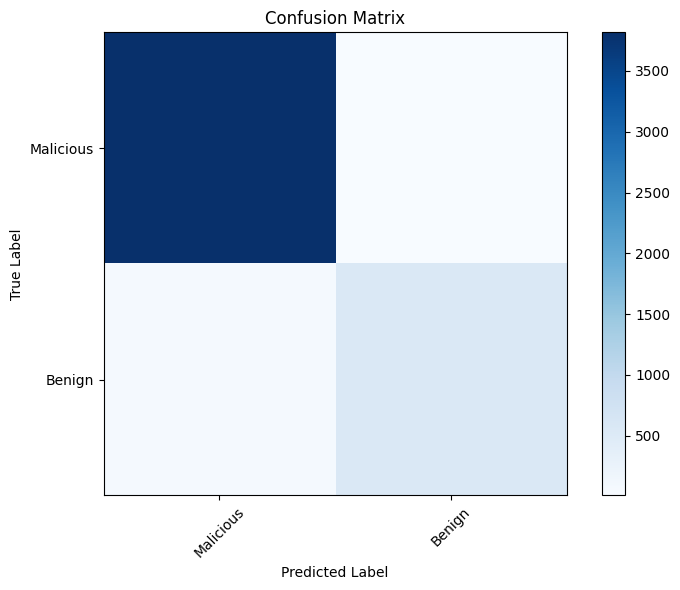

In [37]:
clf, model, data = train_model_and_save_weights(content_column="Content",
                                                vector_size=30,
                                                window=2,
                                                min_count=1,
                                                workers=4,
                                                epochs=30,
                                                depth=8,
                                                iterations=300,
                                                learning_rate=0.2,
                                                zip_name=zip_name,
                                                output_dir=output_dir,
                                                password=password,
                                                csv_name=csv_name,
                                                dataset=dataset,
                                                cat_boost_clf_name=cat_boost_clf_name,
                                                doc2vec_model_name=doc2vec_model_name,
                                                tar_name=tar_name)

### Testing
---
Simple test function that randomly takes 10 files from the malicious and benign folders and checks it using the API function.

In [38]:

def test_function(file_list, dir):

    random.shuffle(file_list)
    selected_files = file_list[:10]
    times = []


    for file in selected_files:
        file_path = os.path.join(dir, file)
        start_time = time.time()
        result = predict_file(file_path, doc2vec_model, cat_boost_clf)
        end_time = time.time()
        print(file_path, result)
        times.append(end_time - start_time)
        
    print(f"Average time: {np.mean(times):.5f} seconds")

In [40]:
malicios_dir = os.path.join(output_dir, "malicious")
file_list = os.listdir(malicios_dir)
test_function(file_list, malicios_dir)

dataset/malicious/6c05cc59e075ecd439f897a0fd21189b1f24b23489a304b0cb6c0bc1a1585c0e True
dataset/malicious/ed9e8062994c845ca179e869b12949d89f34f45705a39cf29167f6d7bf277011 True
dataset/malicious/319f4fc3b6c9e9e85df257b54b2f3c910c4ecd3b45fd3b7467cc07c4252b3a29 True
dataset/malicious/a56027e07628a0f29687e9d39423e1721b3fb7afb28b753512ea0c65f0c7e938 True
dataset/malicious/32256b94ae1f0d2e4cc7efb7608aa16a8c4445a067416828846553137dac7aef True
dataset/malicious/218121bc40ea6168baee11557b64abbffd87c1e6356b67eab8d9d9ef5c209147 True
dataset/malicious/8e61b1edb7f221d80321fbeba721387364a446590db3265cd5b6596e3405189a True
dataset/malicious/c4de19efc2f348e8cc14e03199635fbf82543ca91dad26ec37e5163fa0c73378 True
dataset/malicious/05899421e645b9fcbb35a0563538b3e0a0273913bc5c5d52701201488fdfc97e True
dataset/malicious/3e2b1ddfe15a4c3fbf8d01c4af7de87dbf804b7cef3418d9be1f4f26345f5d77 True
Average time: 0.03923 seconds


In [41]:
benign_dir = os.path.join(output_dir, "students_dataset", "benign")
file_list = os.listdir(benign_dir)
test_function(file_list, benign_dir)

dataset/students_dataset/benign/albertasbel_bash_exit-status.sh False
dataset/students_dataset/benign/lxqt_lxqt_build_all_cmake_projects.sh False
dataset/students_dataset/benign/schuhumi_alpine_kindle_create_release.sh False
dataset/students_dataset/benign/fwaang_linux_shell_padding_zero.sh False
dataset/students_dataset/benign/jvsummeren_bashfiles_base64.sh False
dataset/students_dataset/benign/TheRemote_Ubuntu-Server-raspi4-unofficial_BuildKernelOnRPi.sh False
dataset/students_dataset/benign/rapido-linux_rapido_simple_example.sh False
dataset/students_dataset/benign/HariSekhon_DevOps-Bash-tools_jira_api.sh False
dataset/students_dataset/benign/se7enack_bash_cidrblock.sh False
dataset/students_dataset/benign/4kercc_SSR-Bash-Python_install.sh False
Average time: 0.00750 seconds


### Statistics
---
Calculate our N-Space for provided solution

In [42]:
import numpy as np
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

def n_space_estmtion(X_test, y_test, y_pred):
    # Perform PCA on X_test
    pca = PCA(n_components=1)
    X_test_pca = pca.fit_transform(X_test)

    # Split X_test_pca based on y_pred labels
    sample1 = X_test_pca[:, 0]
    sample2 = X_test_pca[y_pred == 1][:, 0]

    # Perform the Kolmogorov-Smirnov two-sample test
    ks_statistic, ks_p_value = ks_2samp(sample1, sample2)

    # Generate classification report
    report = classification_report(y_test, y_pred)
    
    # Calculate precision and recall from the classification report
    precision = float(report.split()[-4])
    recall = float(report.split()[-2])

    # Calculate the similarity in the n-space (1 - KS similarity)
    n_space_sim = 1 - ks_statistic / np.sqrt(sample1.shape[0] + sample2.shape[0])
    
    # Calculate ks_statistic * precision and ks_statistic * recall
    ks_precision = ks_statistic * precision
    ks_recall = ks_statistic * recall

    # Calculate the n-solution score (similarity * recall * precision)
    n_solution_score = n_space_sim * recall * precision
    
    # Calculate the one-to-n score (n-solution score * ratio of sample sizes)
    one_to_n_score = n_solution_score * (sample2.shape[0] / sample1.shape[0])
    return n_solution_score, one_to_n_score

    #return ks_statistic, ks_p_value, ks_precision, ks_recall, report, n_solution_score, one_to_n_score

n_space_solutionn,one_to_n_score = n_space_estmtion(data["X_test"], data["y_test"], data["y_pred"])


n_space_solutionn

0.9763344814672481